In [16]:
#dataset Link: kaggle.com/datasets/niharika41298/yoga-poses-dataset?resource=download

import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
#from sklearn import tree
#from sklearn.datasets import make_classification

print("Numpy Version:",np.__version__)
print("OpenCV version:",cv2.__version__)

Numpy Version: 1.22.3
OpenCV version: 4.5.5


Example images
downdog 

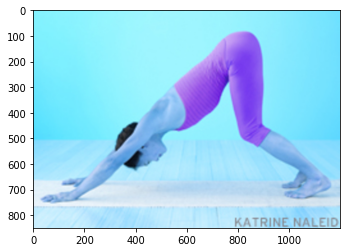

goddess 

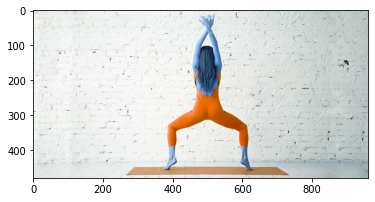

plank 

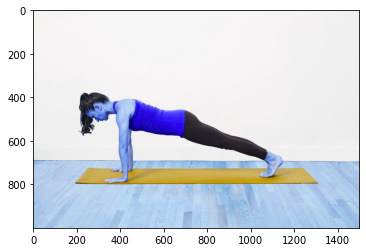

tree 

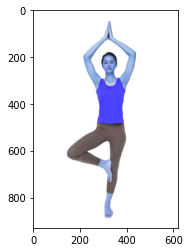

warrior2 

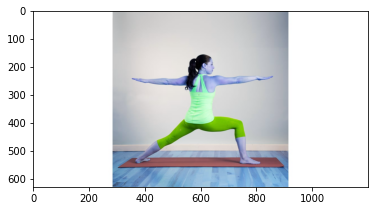

In [17]:
train = "DATASET/TRAIN/"
test = "DATASET/TEST/"

print("Example images")
for d in os.listdir(test):
    print(d,end=" ")
    img=cv2.imread(test+d+"/"+os.listdir(test+d)[np.random.randint(len(os.listdir(test+d)))])
    plt.imshow(img)
    plt.show()

In [18]:
total=0
for d in os.listdir(test):
    print(d,end=" ")
    total+=len(os.listdir(test+d))
    print("images present: ",len(os.listdir(test+d)))
print("Total Test images:",total)      
print()

tot2=0
for d in os.listdir(train):
    print(d,end=" ")
    tot2+=len(os.listdir(train+d))
    print("images present: ",len(os.listdir(train+d)))
print("Total Train images:",tot2) 
total+=tot2;
print("Total Images:",total)
        
PARTS={"Nose":0,"Neck":1,"RShoulder":2,"RElbow":3,"RWrist":4,"LShoulder":5,
      "LElbow":6,"LWrist":7,"RHip":8,"RKnee":9,"RAnkle":10,"LHip":11,"LKnee":12,
      "LAnkle":13,"REye":14,"LEye":15,"REar":16,"LEar":17,"Background":18}

PAIRS=[["Neck","RShoulder"],["Neck","LShoulder"],["RShoulder","RElbow"],
      ["RElbow","RWrist"],["LShoulder","LElbow"],["LElbow","LWrsit"],
      ["Neck","RHip"],["RHip","RKnee"],["RKnee","RAnkle"],["Neck","LHip"],
      ["LHip","LKnee"],["LKnee","LAnkle"],["Neck","Nose"],["Nose","REye"],
      ["REye","REar"],["Nose","LEye"],["LEye","LEar"]]

print("\nBody Parts available:",len(PARTS))
print("Total Number of pairs:",len(PAIRS))
        

downdog images present:  97
goddess images present:  80
plank images present:  115
tree images present:  69
warrior2 images present:  109
Total Test images: 470

downdog images present:  223
goddess images present:  180
plank images present:  266
tree images present:  160
warrior2 images present:  252
Total Train images: 1081
Total Images: 1551

Body Parts available: 19
Total Number of pairs: 17


In [19]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks

data = []
data.append("pose")
for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
head=data;
data = pd.DataFrame(columns = data) # Empty dataset
print("Length of Dataset columns:",len(head))

Length of Dataset columns: 133


Processing Data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved into data.csv


Example data:


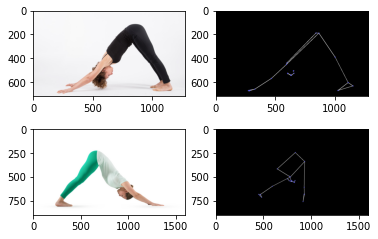

In [20]:
count,p = 0,0
examples=[]
print("Processing Data:")
for D in [test,train]:
    for folder in os.listdir(D):
        for img in os.listdir(D+folder):
                temp = []
                img = cv2.imread(D+folder + "/" + img)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                imageWidth, imageHeight = img.shape[:2]
                imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                blackie = np.zeros(img.shape) # Blank image
                results = pose.process(imgRGB)
                if results.pose_landmarks:

                        # mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS) #draw landmarks on image
                        mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
                        landmarks = results.pose_landmarks.landmark
                        temp=temp+[folder]
                        for i,j in zip(points,landmarks):
                                temp = temp + [j.x, j.y, j.z, j.visibility]
                        data.loc[count] = temp
                        count +=1
                        if len(examples)<2:
                            examples.append([img,blackie])

                if int((count/total)*100) > p:
                    p=int((count/total)*100);
                stat="#"*int(p/2)+"-"*int(50-(p/2))+" "+"{0:.3f}%".format((count/total)*100)
                print(stat,end="\r", flush=True)
                cv2.waitKey(100)
                

'''data['pose']=data['pose'].apply(lambda x:0 if x=='downdog' 
                                else 1 if x=='goddess'
                                else 2 if x=='plank'
                                else 3 if x=='tree'
                                else 4)'''

data.to_csv("data.csv") # save the data as a csv file
print("Saved into data.csv\n\n");

print("Example data:")
fig=plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(examples[0][0])

fig.add_subplot(2,2,2)
plt.imshow(examples[0][1])

fig.add_subplot(2,2,3)
plt.imshow(examples[1][0])

fig.add_subplot(2,2,4)
plt.imshow(examples[1][1])
plt.show()



In [21]:
data=pd.read_csv('data.csv')
print("data shape:",data.shape)
num_of_classes=len(data.pose.unique())
print(num_of_classes)


data shape: (1329, 134)
5


In [22]:
data.head()

,Unnamed: 0,pose,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,0,downdog,0.508779,0.735192,-0.071366,0.997456,0.493383,0.758222,-0.112861,0.998689,...,0.343789,0.482827,0.797215,0.934905,-0.252185,0.975540,0.777496,0.914816,0.243393,0.467666
1,1,downdog,0.488671,0.609469,-0.751016,0.991552,0.507283,0.614835,-0.762855,0.985894,...,0.688213,0.490129,0.568902,0.844049,0.572043,0.924344,0.373502,0.851059,0.574723,0.497835
2,2,downdog,0.539378,0.765981,-0.084369,0.992335,0.556045,0.778583,-0.063912,0.987242,...,-0.096396,0.540766,0.277062,0.882137,0.214420,0.899608,0.268038,0.885941,-0.251772,0.547352
3,3,downdog,0.655291,0.535797,0.488664,0.991769,0.669238,0.543971,0.528218,0.987209,...,0.105673,0.585327,0.196631,0.865839,-0.036483,0.908774,0.996118,0.977765,0.043894,0.587549
4,4,downdog,0.388131,0.755049,-0.051361,0.992228,0.365101,0.744365,-0.090443,0.988192,...,0.390116,0.566471,0.788217,0.933538,-0.092148,0.913649,0.776249,0.917119,0.315195,0.568831


In [23]:
data.describe()

,Unnamed: 0,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
count,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,...,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000
mean,664.000000,0.493240,0.398715,-0.232619,0.952380,0.497312,0.389119,-0.229833,0.953443,0.499784,...,0.175690,0.749981,0.563244,0.828356,0.087163,0.768504,0.429846,0.822831,0.085251,0.746381
std,383.793564,0.159824,0.210588,0.277978,0.041791,0.166010,0.218145,0.272160,0.040240,0.166516,...,0.329856,0.110939,0.266138,0.265528,0.360340,0.107776,0.263160,0.273585,0.350455,0.114766
min,0.000000,-0.364091,-0.197603,-1.783450,0.748442,-0.340366,-0.221073,-1.893833,0.753637,-0.327357,...,-0.947906,0.438293,-1.242565,-1.917830,-0.909977,0.381677,-1.282110,-2.010278,-1.081940,0.427532
25%,332.000000,0.424775,0.234743,-0.376404,0.938761,0.426933,0.220301,-0.360546,0.941414,0.427099,...,-0.002524,0.668716,0.382383,0.731984,-0.126315,0.694332,0.231304,0.723058,-0.113467,0.659070
50%,664.000000,0.495481,0.359837,-0.206979,0.963148,0.501450,0.348134,-0.201231,0.964572,0.505503,...,0.129845,0.751412,0.603804,0.856864,0.019603,0.780913,0.402223,0.852495,0.041290,0.755452
75%,996.000000,0.552171,0.543177,-0.065306,0.981477,0.554816,0.539079,-0.075204,0.981026,0.558489,...,0.301271,0.841135,0.772413,0.925679,0.234661,0.858238,0.611767,0.924753,0.230437,0.839302
max,1328.000000,1.420018,2.173107,0.968532,0.997971,1.434417,2.177620,0.969326,0.998689,1.433833,...,4.157464,0.956312,1.567009,2.874683,3.825130,0.975540,1.568087,2.994283,3.990809,0.950831


In [24]:
x=data.drop(axis=0, columns=['pose'])
y=data.pose

print(x.shape)
print(y.shape)
data_train,data_test,y_train,y_test=train_test_split(x,y,
                                                     shuffle=True,
                                                    test_size=0.3,
                                                    random_state=1)
evalset = [(data_train, y_train), (data_test,y_test)]
print("Data Train:",data_train.shape)
print("Data Test:",data_test.shape)
print("label Train:",y_train.shape)
print("label Test:",y_test.shape)

(1329, 133)
(1329,)
Data Train: (930, 133)
Data Test: (399, 133)
label Train: (930,)
label Test: (399,)


In [25]:
# Create a classifier
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="mlogloss", num_class=num_of_classes)
e_xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="auc", num_class=num_of_classes)

# Fit the classifier with the training data
xgb.fit(data_train,y_train, eval_set=evalset)
e_xgb.fit(data_train,y_train, eval_set=evalset)

[0]	validation_0-mlogloss:1.00802	validation_1-mlogloss:1.05016
[1]	validation_0-mlogloss:0.69620	validation_1-mlogloss:0.75460
[2]	validation_0-mlogloss:0.49765	validation_1-mlogloss:0.56527
[3]	validation_0-mlogloss:0.36259	validation_1-mlogloss:0.43429
[4]	validation_0-mlogloss:0.26808	validation_1-mlogloss:0.34224


C:\Users\Shivanshu\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Shivanshu\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[5]	validation_0-mlogloss:0.19909	validation_1-mlogloss:0.27244
[6]	validation_0-mlogloss:0.14956	validation_1-mlogloss:0.22263
[7]	validation_0-mlogloss:0.11313	validation_1-mlogloss:0.18401
[8]	validation_0-mlogloss:0.08681	validation_1-mlogloss:0.15514
[9]	validation_0-mlogloss:0.06649	validation_1-mlogloss:0.13103
[10]	validation_0-mlogloss:0.05184	validation_1-mlogloss:0.11338
[11]	validation_0-mlogloss:0.04046	validation_1-mlogloss:0.09937
[12]	validation_0-mlogloss:0.03236	validation_1-mlogloss:0.09082
[13]	validation_0-mlogloss:0.02627	validation_1-mlogloss:0.08304
[14]	validation_0-mlogloss:0.02100	validation_1-mlogloss:0.07482
[15]	validation_0-mlogloss:0.01744	validation_1-mlogloss:0.06993
[16]	validation_0-mlogloss:0.01441	validation_1-mlogloss:0.06541
[17]	validation_0-mlogloss:0.01199	validation_1-mlogloss:0.06042
[18]	validation_0-mlogloss:0.01040	validation_1-mlogloss:0.05783
[19]	validation_0-mlogloss:0.00918	validation_1-mlogloss:0.05761
[20]	validation_0-mlogloss:0.0

[37]	validation_0-auc:1.00000	validation_1-auc:0.99867
[38]	validation_0-auc:1.00000	validation_1-auc:0.99865
[39]	validation_0-auc:1.00000	validation_1-auc:0.99862
[40]	validation_0-auc:1.00000	validation_1-auc:0.99858
[41]	validation_0-auc:1.00000	validation_1-auc:0.99849
[42]	validation_0-auc:1.00000	validation_1-auc:0.99853
[43]	validation_0-auc:1.00000	validation_1-auc:0.99848
[44]	validation_0-auc:1.00000	validation_1-auc:0.99844
[45]	validation_0-auc:1.00000	validation_1-auc:0.99835
[46]	validation_0-auc:1.00000	validation_1-auc:0.99837
[47]	validation_0-auc:1.00000	validation_1-auc:0.99833
[48]	validation_0-auc:1.00000	validation_1-auc:0.99835
[49]	validation_0-auc:1.00000	validation_1-auc:0.99830
[50]	validation_0-auc:1.00000	validation_1-auc:0.99833
[51]	validation_0-auc:1.00000	validation_1-auc:0.99828
[52]	validation_0-auc:1.00000	validation_1-auc:0.99821
[53]	validation_0-auc:1.00000	validation_1-auc:0.99821
[54]	validation_0-auc:1.00000	validation_1-auc:0.99825
[55]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

In [26]:
# Use trained model to predict output of test dataset
val = xgb.predict(data_test)
e_val = e_xgb.predict(data_test)

acc_score=accuracy_score(y_test,val)
e_acc_score=accuracy_score(y_test,e_val)
print("multiclass logloss Accuracy:",acc_score)
print("multiclass error Accuracy:",acc_score)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
val_lb = lb.transform(val)

roc_score=roc_auc_score(y_test_lb, val_lb, average='macro')

print("\nroc_score(mlogloss):",roc_score)
print()

multiclass logloss Accuracy: 0.9849624060150376
multiclass error Accuracy: 0.9849624060150376

roc_score(mlogloss): 0.9899481164694368



In [27]:
output = pd.DataFrame()
output['Expected Output'] = y_test
output['Predicted Output'] = val
output.head()


,Expected Output,Predicted Output
453,downdog,downdog
1129,warrior2,warrior2
1118,warrior2,warrior2
115,goddess,goddess
1153,warrior2,warrior2


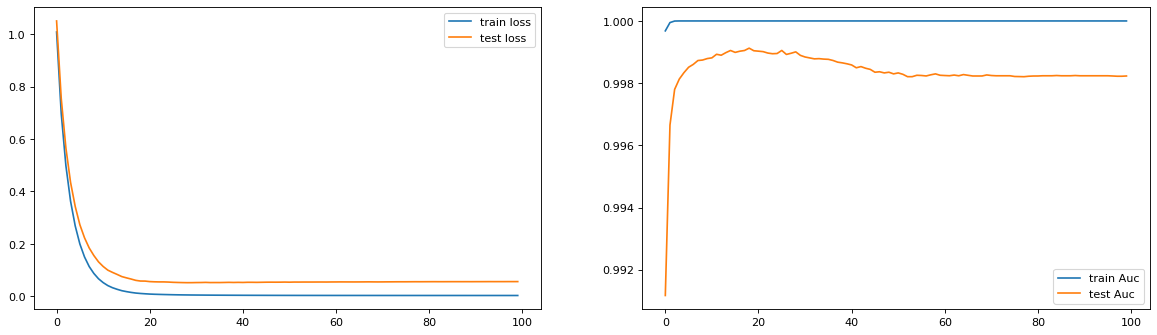

In [28]:
results = xgb.evals_result()
e_results = e_xgb.evals_result()

fig=plt.figure(figsize=(18, 5), dpi=80)
fig.add_subplot(1,2,1)
plt.plot(results['validation_0']['mlogloss'], label='train loss')
plt.plot(results['validation_1']['mlogloss'], label='test loss')
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(e_results['validation_0']['auc'], label='train Auc')
plt.plot(e_results['validation_1']['auc'], label='test Auc')
plt.legend()
plt.show()